In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import math
import datetime
import requests
import statsmodels.api as sm
import statsmodels.stats.outliers_influence
from statsmodels.formula.api import glm

# Settings
## Countries to Plot

In [2]:
countries_asia = ["China", "Singapore", "Vietnam", "South_Korea"]
countries_europe = ["Italy", "Spain", "Germany","France", "Slovakia", "Switzerland", "United_Kingdom", "Norway"]
countries_americas = ["United_States_of_America"]
countries_europe_additional = ["Netherlands", "Belgium", "Portugal", "Sweden", "Denmark", "Czechia", "Ireland",
                    "Finland", "Poland", "Greece", "Iceland", "Romania", "Slovenia", "Estonia", "Bulgaria", "Latvia",
                    "Hungary", "Lithuania", "Bosnia and Herzegovina", "Malta", "Albania", "Liechtenstein", "Luxembourg",]
countries_all = countries_asia + countries_europe + countries_americas + ["Austria"]

# Preperation
## Loading Data from ECDC
Based upon the COVID-19 time series from ECDC
Source: https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide

The ECDC case data is automatically loaded from the ECDCs website. First a check is performed whether the data for today is already available, if not the previous days data is loaded. 

In [3]:
download_date = datetime.datetime.utcnow()
url_template = "https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-%s.xlsx"
url = url_template % download_date.strftime("%Y-%m-%d")
resp = requests.head(url)
if not resp.ok:
    download_date = download_date - datetime.timedelta(days=1)
    url = url_template % download_date.strftime("%Y-%m-%d")

In [4]:
df = pd.read_excel(url)
df = df.iloc[::-1]

In [21]:
df[df["countriesAndTerritories"]=="Austria"]

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,cumsum
490,2019-12-31,31,12,2019,0,0,Austria,AT,AUT,8847037.0,0
489,2020-01-01,1,1,2020,0,0,Austria,AT,AUT,8847037.0,0
488,2020-01-02,2,1,2020,0,0,Austria,AT,AUT,8847037.0,0
487,2020-01-03,3,1,2020,0,0,Austria,AT,AUT,8847037.0,0
486,2020-01-04,4,1,2020,0,0,Austria,AT,AUT,8847037.0,0
...,...,...,...,...,...,...,...,...,...,...,...
407,2020-03-23,23,3,2020,607,8,Austria,AT,AUT,8847037.0,3631
406,2020-03-24,24,3,2020,855,9,Austria,AT,AUT,8847037.0,4486
405,2020-03-25,25,3,2020,796,5,Austria,AT,AUT,8847037.0,5282
404,2020-03-26,26,3,2020,606,4,Austria,AT,AUT,8847037.0,5888


In [6]:
df['cumsum'] = df.groupby("countriesAndTerritories")['cases'].transform(pd.Series.cumsum)
#df = df.set_index("DateRep")

In [7]:
df_total = df.pivot(index='dateRep', columns='countriesAndTerritories', values='cumsum')
df_population = df.pivot(index='dateRep', columns='countriesAndTerritories', values='popData2018')
df_country_code = df.pivot(index='dateRep', columns='countriesAndTerritories', values='countryterritoryCode')

## Loading Data from DXY

Source repository: https://github.com/BlankerL/DXY-COVID-19-Data

In [8]:
df_dxy = pd.read_csv('data/DXY-COVID-19-Data/csv/DXYArea.csv', parse_dates=["updateTime"])
def dtm_dxy(x):
    try:
        return datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S.%f")
    except:        
        return datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")
df_dxy["updateTime"] = df_dxy["updateTime"].apply(dtm_dxy)
df_dxy = df_dxy.set_index('updateTime')

## Data Transformation

In [9]:
x = np.linspace(1, len(df_total["Austria"]), num=len(df_total["Austria"]))
latest_date = datetime.datetime.strftime(df_total["Austria"].index[-1], "%Y-%m-%d")

In [10]:
latest_date

'2020-03-27'

## Poisson Regression, Doubling Time Estimation and Plot

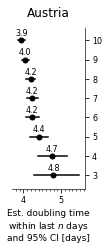

In [11]:
def days_rel_to_absolute(df, x):
    return [df.index[0] + datetime.timedelta(days=day-1) for day in x]

def estimate_t2_poisson_regression(data, last_days = 5, alpha=0.05):
    offset= len(data) - last_days
    data_trunc = data[-last_days:]
    y = data_trunc.values.astype("float64")
    x = np.linspace(offset+1, last_days+offset, num=abs(last_days))

    model = glm('y ~ x',
        data = data_trunc,
        family = sm.families.Poisson()
    ).fit()
    
    t2_est = np.log(2)/model.params['x']
    
    ci = model.conf_int(alpha)
    t2_ci_lower = np.log(2)/ci[1]["x"]
    t2_ci_upper = np.log(2)/ci[0]["x"]
    
    return (t2_est, t2_ci_lower, t2_ci_upper, model)

fig, ax = plt.subplots(figsize=(1.5,3.35))

for i in range(3, 11):
    est = estimate_t2_poisson_regression(df_total["Austria"][:], i)
    plt.plot(est[0], i, "ko", markersize=5)
    plt.plot([est[1], est[2]], np.ones(2)*i, "k")
    ax.annotate("%.1f" % est[0], xy=(est[0], i+0.23), horizontalalignment="center", fontsize=8)
#ax.set_ylabel("Poisson regression over last $n$ days", fontsize=9)
ax.set_xlabel("Est. doubling time\nwithin last $n$ days\nand 95% CI [days]", fontsize=9)
ax.set_title("Austria", fontsize=12, pad=10)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.tick_params(labelsize=8)
plt.margins(0.1, 0.1)

ax.spines['bottom'].set_color('#333333')
ax.spines['top'].set_color('#ffffff') 
ax.spines['right'].set_color('#333333')
ax.spines['left'].set_color('#ffffff')

fig.subplots_adjust(bottom=0.21, right=0.8)
fig.savefig('inset-poisson-regression-%s.png' % latest_date, dpi=160)

# Combined Data Plot, logarithmic

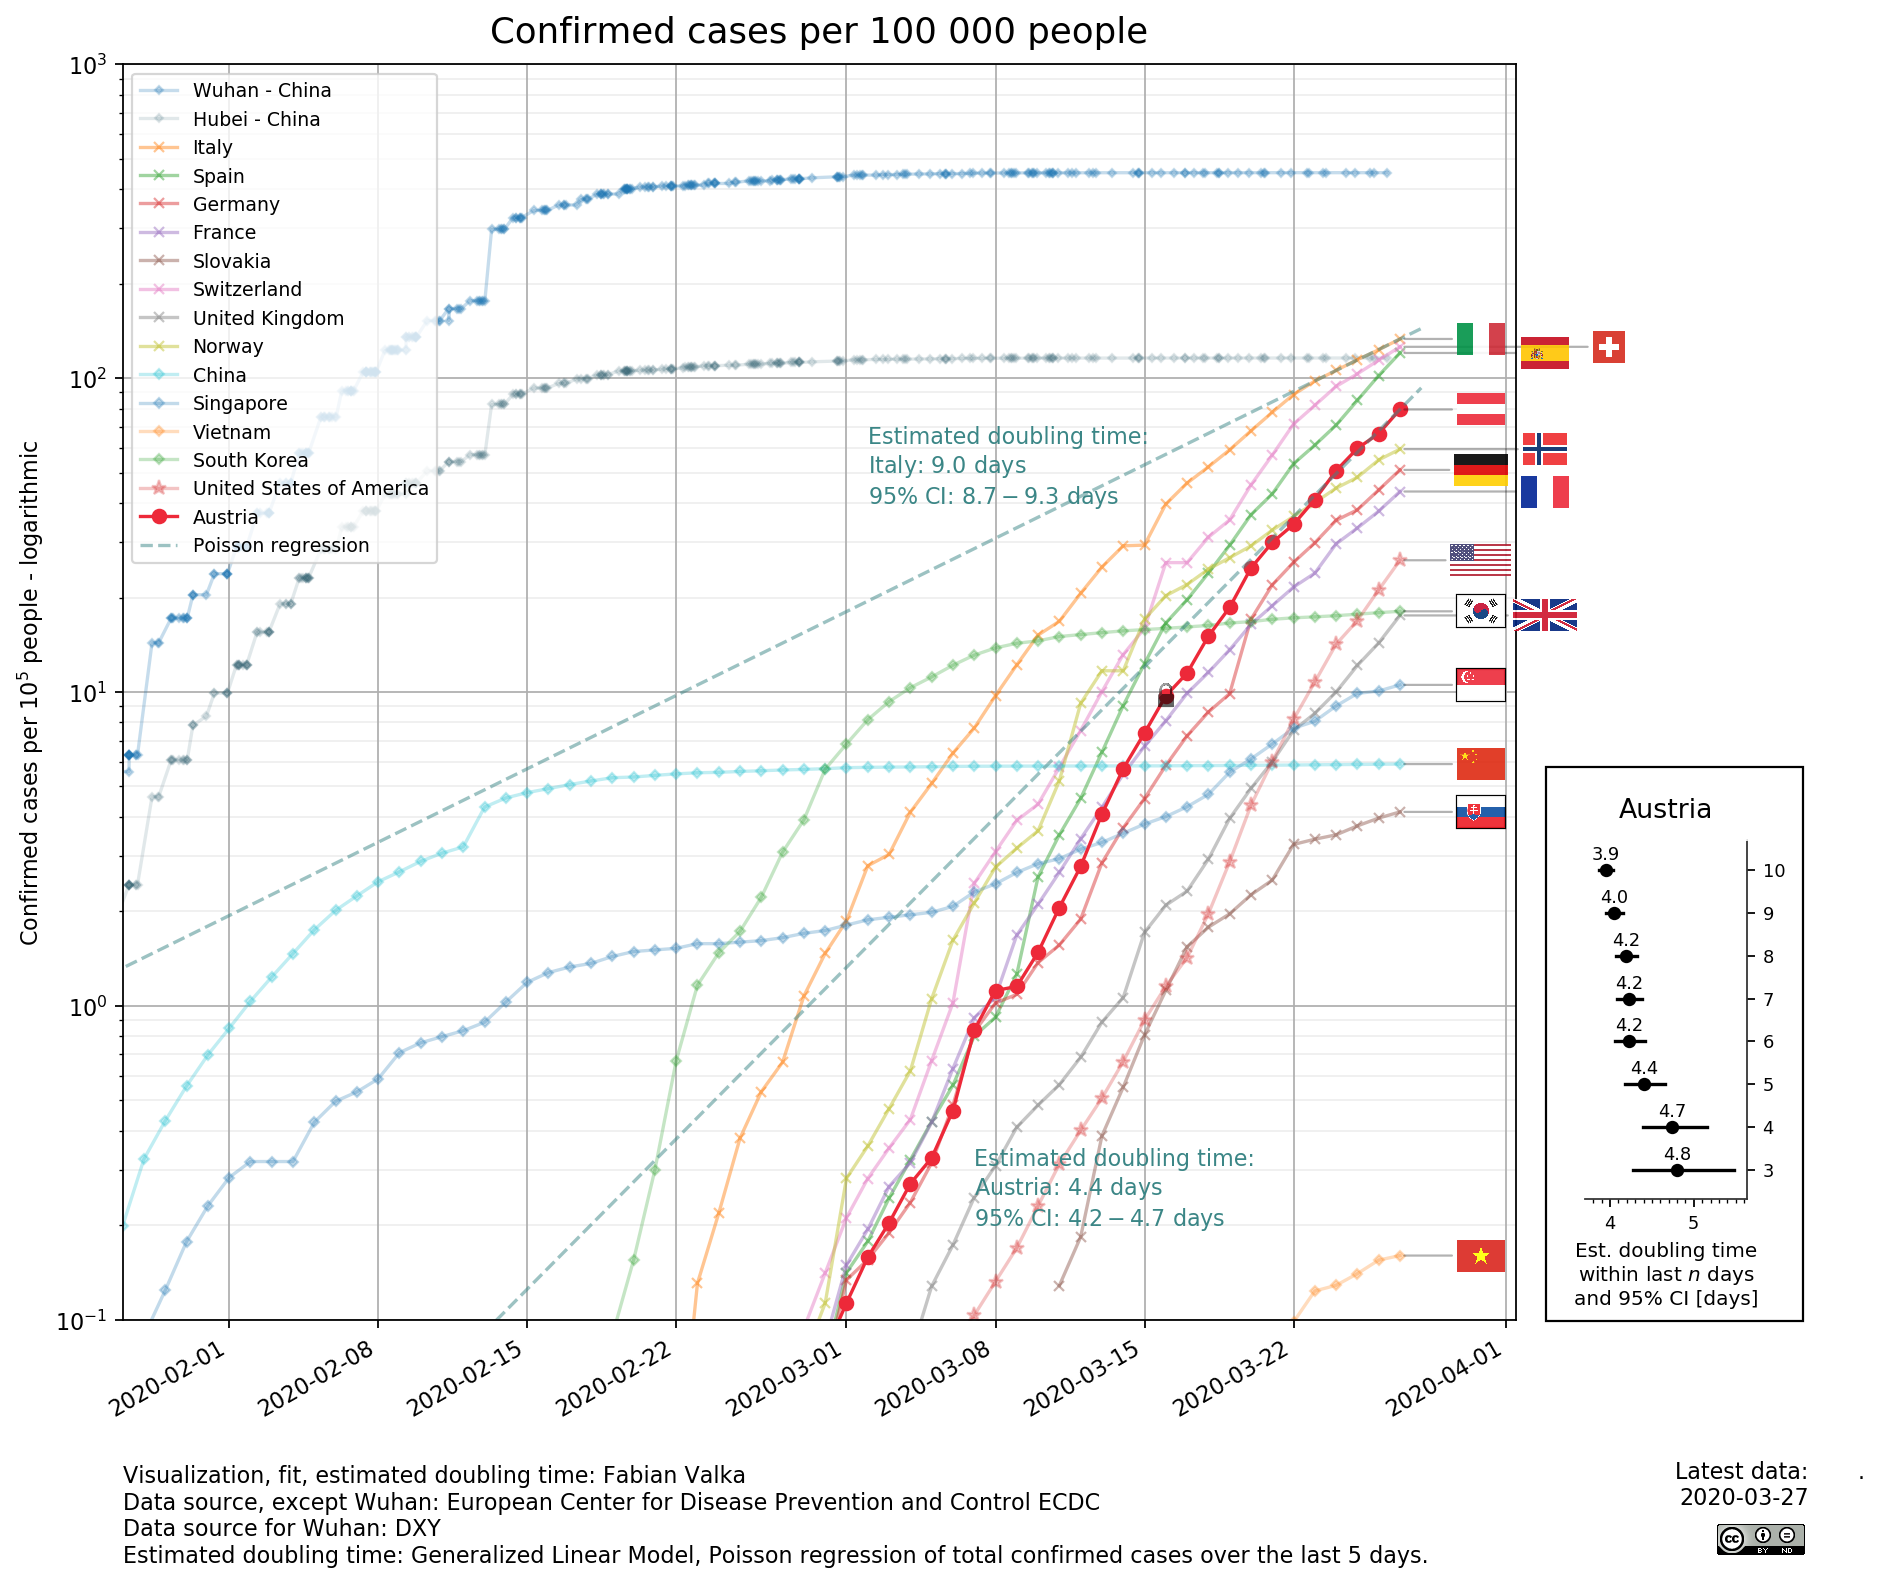

In [12]:
fig, ax = plt.subplots(figsize=(12,10), dpi=160)

def get_per_capita(df, countries):
    return df_total[countries]/df_population[countries]*10**5

# Wuhan city, China
(df_dxy[df_dxy["cityEnglishName"]=="Wuhan"]["city_confirmedCount"]/(11.08*10**6)*10**5) \
.plot(ax=ax, style="-", alpha=0.25, marker="D", markersize=2.3)

# Hubei province, China
(df_dxy[df_dxy["cityEnglishName"]=="Wuhan"]["province_confirmedCount"]/(58.5*10**6)*10**5) \
.plot(ax=ax, style="-", alpha=0.15, marker="D", markersize=2.3, color="#3b6978")

# Plotting
get_per_capita(df_total, countries_europe).plot(ax=ax, style="-", alpha=0.45, marker="x", markersize=4.5)
get_per_capita(df_total, countries_asia).plot(ax=ax, style="-", alpha=0.27, marker="D", markersize=2.9)
get_per_capita(df_total, countries_americas).plot(ax=ax, style="-", alpha=0.27, marker="*", markersize=7.0)
plt.plot(get_per_capita(df_total, ["Austria"]), "o-", color="#ED2939")

# Fit
# Austria
x_fit = np.linspace(0, len(df_total)+1, num=len(df_total)*10)
t2_est, t2_ci_lower, t2_ci_upper, t2_model = estimate_t2_poisson_regression(df_total["Austria"])

ax.plot(days_rel_to_absolute(df_total, x_fit), 
        t2_model.predict(pd.DataFrame({'x':x_fit}))/df_population["Austria"][-1]*10**5, 
        "--", alpha=0.5, color='#3B8686')

T2_text = "Estimated doubling time:\nAustria: $%.1f$ days\n95%% CI: $%.1f-%.1f$ days" % (t2_est, t2_ci_lower, t2_ci_upper)
ax.annotate(T2_text, xy=(pd.to_datetime("2020-03-07"), 0.2), color='#3B8686')

# Italy
x_fit = np.linspace(0, len(df_total)+1, num=len(df_total)*10)
t2_est, t2_ci_lower, t2_ci_upper, t2_model = estimate_t2_poisson_regression(df_total["Italy"])

ax.plot(days_rel_to_absolute(df_total, x_fit), 
        t2_model.predict(pd.DataFrame({'x':x_fit}))/df_population["Italy"][-1]*10**5, 
        "--", alpha=0.5, color='#3B8686')

T2_text = "Estimated doubling time:\nItaly: $%.1f$ days\n95%% CI: $%.1f-%.1f$ days" % (t2_est, t2_ci_lower, t2_ci_upper)
ax.annotate(T2_text, xy=(pd.to_datetime("2020-03-02"), 40), color='#3B8686')

# Plot decoration
legend_names = ["Wuhan - China", "Hubei - China"] + countries_europe + countries_asia + \
           countries_americas + ["Austria" ,"Poisson regression"]
legend_names = [elem.replace("_", " ") for elem in legend_names]
plt.legend(legend_names, fontsize=8.5, loc='upper left')
ax.grid(True)
ax.grid(True, 'minor', alpha=0.2)
ax.set_title(r'Confirmed cases per 100 000 people', fontsize=16, pad=10)
ax.set_xlabel(None)
ax.set_ylabel("Confirmed cases per $10^5$ people - logarithmic")
ax.set_yscale('log')
ax.tick_params(axis='y', which='minor', bottom=False)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(np.linspace(0,1,num=11)),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# Annotations
def annotate_country_event(df, country, day, text):
    val = df[country][day]/get_population(country)*10**5
    x_pos = pd.to_datetime(day)
    x_text = pd.to_datetime("2020-03-01")
    ax.annotate(text, xy=(x_pos, val),
                xytext=(x_text, val),
                horizontalalignment='right',
                arrowprops=dict(facecolor='black', arrowstyle='-', alpha=0.4),
                alpha=0.6, fontsize=9.5
                )
    

# Add inset 
arr_img = plt.imread('inset-poisson-regression-%s.png' % latest_date, format='png')

imagebox = OffsetImage(arr_img, dpi_cor=False)
imagebox.image.axes = ax

ab = AnnotationBbox(imagebox, (1.112,0.219),
                    xycoords='axes fraction',
                    boxcoords="offset points"
                    )

ax.add_artist(ab)

# Flags
y_lower = ax.transData.transform((0, ax.get_ybound()[0]))[1]
y_upper = ax.transData.transform((0, ax.get_ybound()[1]))[1]

grid_n = 60

base_offset = 3.8
each_level_offset = 3.0

grid_depth = 5 

flag_positions = list()
flag_height = 32
flag_pad_x = 0

def add_flag(df, country, short_code, xpos=None, ypos=None, frame=False):
    arr_img = plt.imread('data/country-flag-icons/images/png/%s.png' % short_code.lower(), format='png')
    
    if xpos is None:
        xpos = pd.to_datetime(latest_date)
        ypos = df[country][latest_date]/df_population[country][-1]*10**5
        
        
    y_on_artist = ax.transData.transform((0, ypos))[1]
    
    y_rel = y_on_artist - y_lower
    
    offset = base_offset
    depth = 0
    
    collision_free = False
    while not collision_free:
        collision_free = True
        for flag in flag_positions:
            if abs(flag[0] - y_rel) < flag_height/2 + flag_pad_x:
                if flag[1] == depth:
                    depth = depth + 1
                    collision_free = False
    
    flag_positions.append((y_rel, depth))
    
    offset = base_offset + depth * each_level_offset
    xpos_box = xpos + pd.Timedelta(offset, "D")
    
    zoom = flag_height/arr_img.shape[0]

    imagebox = OffsetImage(arr_img, dpi_cor=False, zoom=zoom,alpha=0.9)
    imagebox.image.axes = ax

    ab = AnnotationBbox(imagebox, 
                        xy=(xpos, ypos),
                        xybox=(xpos_box, ypos),
                        pad=0,frameon=frame,
                        arrowprops=dict(facecolor='black', arrowstyle='-', alpha=0.3))
    ab.set_zorder(100 - offset)
    ax.add_artist(ab)

flags_with_frame = ["Slovakia", "Singapore", "South_Korea"]
for country in countries_all:
    add_flag(df_total, country, df_country_code[country][-1],frame=country in flags_with_frame)

def add_lockdown(df, country, date):
    arr_img = plt.imread('lock.png', format='png')
    
    xpos = pd.to_datetime(date)
    ypos = df[country][date]/df_population[country][-1]*10**5
        
    imagebox = OffsetImage(arr_img, dpi_cor=False, zoom=0.07, alpha=0.6)
    imagebox.image.axes = ax

    ab = AnnotationBbox(imagebox, 
                        xy=(xpos, ypos),
                        pad=0, frameon=False,
                        arrowprops=dict(facecolor='black', arrowstyle='-', alpha=0.3))
    ax.add_artist(ab)
    
add_lockdown(df_total, "Austria", "2020-03-16")
#add_lockdown(df_total, "United_Kingdom", "2020-03-23")
#add_lockdown(df_total, "Italy", "2020-03-09")
#add_lockdown(df_total, "France", "2020-03-17")
#add_lockdown(df_total, "Spain", "2020-03-14")
# Source and notes
ax.annotate('Visualization, fit, estimated doubling time: Fabian Valka\n' + 
            'Data source, except Wuhan: European Center for Disease Prevention and Control ECDC\n'
            'Data source for Wuhan: DXY\n' +
           r'Estimated doubling time: Generalized Linear Model, Poisson regression of total confirmed cases over the last 5 days.', 
            (0,0), (0, -65), xycoords='axes fraction', textcoords='offset points', va='top')

ax.annotate('Latest data:\n%s' % latest_date, 
            (1.21,0), (0, -63), xycoords='axes fraction', textcoords='offset points', va='top', horizontalalignment="right")

# workaround for scaling of plot, since padding and tight layout are missing the box above
ax.annotate('.', 
            (1.25,0), (0, -63), xycoords='axes fraction', textcoords='offset points', va='top', horizontalalignment="right")

# Add licence image
# Add inset 
arr_img = plt.imread('cc-by-nd.png', format='png')

imagebox = OffsetImage(arr_img, dpi_cor=False)
imagebox.image.axes = ax

ab = AnnotationBbox(imagebox, (1.174,-0.175),
                    xycoords='axes fraction',
                    boxcoords="offset points",
                    frameon=False
                    )

ax.add_artist(ab)

ax.set_xlim(df_total["Austria"].index[-61], )
ax.set_ylim(0.1,10**3)

fig.tight_layout()
fig.savefig('confirmed-cases-per-capita-%s.png' % latest_date, dpi=160)

### Quality of Fit for Poisson Regression

In [13]:
t2_est, t2_ci_lower, t2_ci_upper, t2_model = estimate_t2_poisson_regression(df_total["Austria"])
t2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                    5
Model:                            GLM   Df Residuals:                        3
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32.251
Date:                Fri, 27 Mar 2020   Deviance:                       12.596
Time:                        20:20:27   Pearson chi2:                     12.6
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.9949      0.382    -13.064      0.000      -5.744      -4.246
x              0.1574      0.004     35.544      0.000       0.149       0.166
==============================================================================
"""

In [14]:
t2_model.get_influence().summary_frame()

,dfb_Intercept,dfb_x,cooks_d,standard_resid,hat_diag,dffits_internal
0,-2.603165,2.578468,4.529432,-2.804454,0.535273,-3.009795
1,0.852870,-0.838630,0.747669,1.804364,0.314737,1.222840
2,0.273360,-0.255022,0.681610,2.299935,0.204906,1.167571
3,0.505001,-0.522085,0.693252,-1.868323,0.284287,-1.177499
4,0.137200,-0.139066,0.016240,-0.129123,0.660798,-0.180222


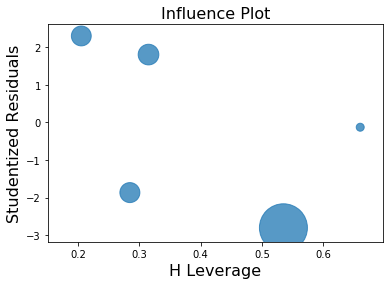

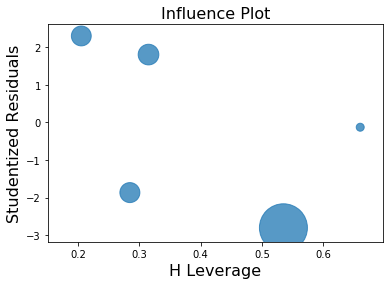

In [15]:
t2_model.get_influence().plot_influence()

In [16]:
t2_model.tvalues

Intercept   -13.064303
x            35.544021
dtype: float64

# Austria and Italy Total number of cases

## Austria

In [17]:
df_total["Austria"][-1]

7029.0

## Italy

In [18]:
df_total["Italy"][-1]

80539.0